## Object detection without Strided Inference using openCV dnn module

In [21]:
### Importing useful libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

In [78]:
# load the COCO class names
with open('../learnopencv/Deep-Learning-with-OpenCV-DNN-Module/input/object_detection_classes_coco.txt', 'r') as f:
    class_names = f.read().split('\n')
    
#get a different color array for each of the classes
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

In [79]:
# load the DNN model
model = cv2.dnn.readNet(model='../learnopencv/Deep-Learning-with-OpenCV-DNN-Module/input/frozen_inference_graph.pb',
                        config='../learnopencv/Deep-Learning-with-OpenCV-DNN-Module/input/ssd_mobilenet_v2_coco_2018_03_29.pbtxt.txt',
                        framework='TensorFlow')

### Let's review a case where such solutions do work quite well

In [98]:
# Defining detection function
def det(imag):
    image = imag.copy()
    # create blob from image
    blob = cv2.dnn.blobFromImage(image=image, size=(300, 300), mean=(104, 117, 123), swapRB=True)
    # set the blob to the model
    model.setInput(blob)
    # forward pass through the model to carry out the detection
    out = model.forward()
    
    return out

In [99]:
#Defininng display function
def display_box(image, output, confidence_threshold = 0.3):
    image_height, image_width, _ = image.shape
    # loop over each of the detection
    for detection in output[0, 0, :, :]:
        # extract the confidence of the detection
        confidence = detection[2]
        # draw bounding boxes only if the detection confidence is above...
        # ... a certain threshold, else skip
        if confidence > confidence_threshold:
            # get the class id
            class_id = detection[1]
            # map the class id to the class
            class_name = class_names[int(class_id)-1]
            color = COLORS[int(class_id)]
            # get the bounding box coordinates
            box_x = detection[3] * image_width
            box_y = detection[4] * image_height
            # get the bounding box width and height
            box_width = detection[5] * image_width
            box_height = detection[6] * image_height
            # draw a rectangle around each detected object
            cv2.rectangle(image, (int(box_x), int(box_y)), (int(box_width), int(box_height)), color, thickness=3)
            # put the FPS text on top of the frame
            cv2.putText(image, class_name, (int(box_x), int(box_y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return image

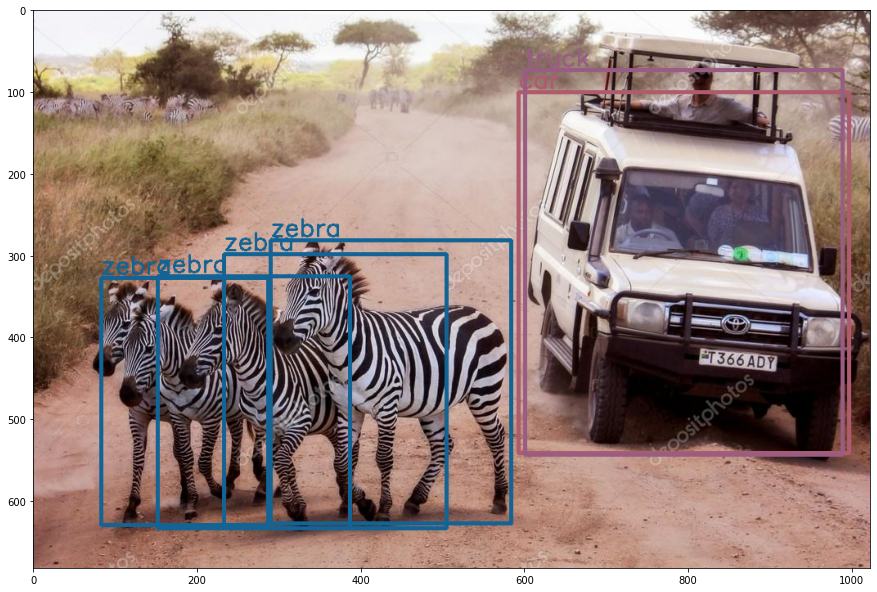

In [100]:
# read the image from disk
img = cv2.imread('openCV_dnn/img3.jpg')
result = det(img)

image_out = display_box(img, result, confidence_threshold= 0.3)

### Uncomment the code below to get the image with bounding boxes as output        
# cv2.imwrite('image_result.jpg', image_out)

### But this isn't always the case. Many a times the image is of such high resolution that such solution just don't work at optimum level or at all. Let's review such a case

### There is only one detection in this image as we can see below

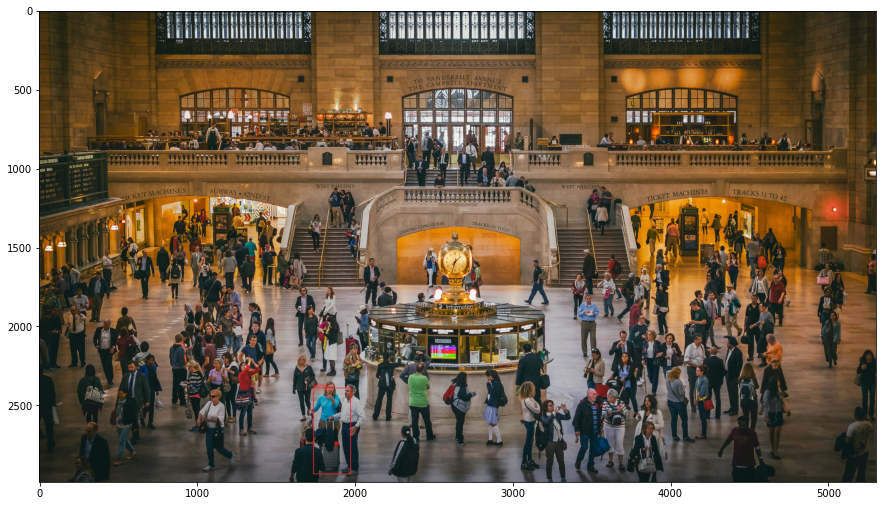

True

In [101]:
# read the image from disk
img = cv2.imread('openCV_dnn/img6.jpg')

result = det(img)
image_out = display_box(img, result, confidence_threshold=0.3)

## Uncomment the code below to get the image with bounding boxes as output        
cv2.imwrite('image_result.jpg', image_out)

### On close observation we see it ends up missing lot of people that are present in this photo. In fact I believe there is only single human detected.

### NOTE: We are only using detections that have confidence above 0.3, this is the lowest accepted confidence. Using a bit lower than that will lead to show lot more detections, but with low confidence.

# Now let's try Strided Inference

In [102]:
from stridedinference.stridedInference import stridedInference

### Detector function definition example:

User has to create or define a function that can take a folder path containing images and gives back a dataframe containing information of all the detections we get on all of them.

The final structure of the detections should be of the following format:
```
['filename', 'label', 'xmin', 'xmax', 'ymin', 'ymax', 'confidence']
```

In [103]:
def detector(folder_path, verbose_count = 30):
    '''Detector that returns back detections on a 
    folder of images.
    
    Parameters
    ----------
    folder_path : str
        Directory containing images.
    verbose_count : int
        Print frequency of the number of tiles processed.
    '''
    with open('../learnopencv/Deep-Learning-with-OpenCV-DNN-Module/input/object_detection_classes_coco.txt', 'r') as f:
        class_names = f.read().split('\n')
    
    
    
    # load the DNN model
    model = cv2.dnn.readNet(model='../learnopencv/Deep-Learning-with-OpenCV-DNN-Module/input/frozen_inference_graph.pb',
                            config='../learnopencv/Deep-Learning-with-OpenCV-DNN-Module/input/ssd_mobilenet_v2_coco_2018_03_29.pbtxt.txt',
                            framework='TensorFlow')
    
    ret = pd.DataFrame(columns=['filename', 'label', 'xmin', 'xmax', 'ymin', 'ymax', 'confidence'])
    
    print("Detection Starts")
    
    count = 0
    for img in glob.glob(folder_path+"/*.jpg"):
        count+=1
        
        image = cv2.imread(img)
        image_height, image_width, _ = image.shape
        # create blob from image
        blob = cv2.dnn.blobFromImage(image=image, size=(300, 300), mean=(104, 117, 123), swapRB=True)
        # set the blob to the model
        model.setInput(blob)
        # forward pass through the model to carry out the detection
        output = model.forward()
        
        output = pd.DataFrame(output[0,0,:,:])
        
        output.rename(mapper= {0:'filename', 1:'label', 2:'confidence', 3:'xmin', 4:'ymin', 5:'xmax', 6:"ymax"}, axis=1, inplace=True)
        
        output['filename'] = os.path.basename(img)
        
        output = output[ret.columns]
        output.replace({"label": dict(zip(range(1,len(class_names)), class_names))}, inplace=True)
        ret = ret.append(output, sort=False, ignore_index=True)
        
        if count%verbose_count==0:
            print(f"{count} tiles done")
    
    print("End of Detection")
    return ret

### Loading the same image and performing detection using stridedInferece

In [115]:
img_name = 'img6.jpg'
image = cv2.imread(f'openCV_dnn/{img_name}')

out2 = stridedInference(image, img_name, detector, tile_size_info=(900, 700, 701), nms_th=0.95)

Detection Starts
30 tiles done
End of Detection


### Code below just creates bounding box over the detections we received

In [117]:
#get a different color array for each of the classes
# COLORS = dict(zip(class_names, np.random.uniform(0, 255, size=(len(class_names), 3))))

#Reading the class_names to assign colour to bounding box
with open('../learnopencv/Deep-Learning-with-OpenCV-DNN-Module/input/object_detection_classes_coco.txt', 'r') as f:
    class_names = f.read().split('\n')

# loop over each of the detection
for detection in out2.values:
    # extract the confidence of the detection
    confidence = detection[-1]
    # draw bounding boxes only if the detection confidence is above...
    # ... a certain threshold, else skip
    if confidence > .3:
        # get the class id
        # map the class id to the class
        class_name = detection[1]
        color = COLOR[class_name]
        # get the bounding box coordinates
        box_x = detection[2]
        box_y = detection[4]
        # get the bounding box width and height
        box_width = detection[3]
        box_height = detection[5]
        # draw a rectangle around each detected object
        cv2.rectangle(image, (int(box_x), int(box_y)), (int(box_width), int(box_height)), color, thickness=4)
        # put the FPS text on top of the frame
        cv2.putText(image, class_name, (int(box_x), int(box_y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

        
### Uncomment the code below to get the image with bounding boxes as output        
#cv2.imwrite('result_with_strided.jpg', image)

In [112]:
#get a different color array for each of the classes
COLOR = dict(zip(class_names, COLORS))

def display_box_strided(image, output, confidence_threshold = 0.3):
    image_height, image_width, _ = image.shape
    
    # loop over each of the detection
    for detection in output.values:
        # extract the confidence of the detection
        confidence = detection[-1]
        # draw bounding boxes only if the detection confidence is above...
        # ... a certain threshold, else skip
        if confidence > confidence_threshold:
            # get the class id
            class_name = detection[1]

            color = COLOR[class_name]
            # get the bounding box coordinates
            box_x = detection[2]
            box_y = detection[4]
            # get the bounding box width and height
            box_width = detection[3]
            box_height = detection[5]
            # draw a rectangle around each detected object
            cv2.rectangle(image, (int(box_x), int(box_y)), (int(box_width), int(box_height)), color, thickness=4)
            # put the FPS text on top of the frame
            cv2.putText(image, class_name, (int(box_x), int(box_y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return image

### Running detection using Strided Inference and displaying the result

Detection Starts
30 tiles done
End of Detection


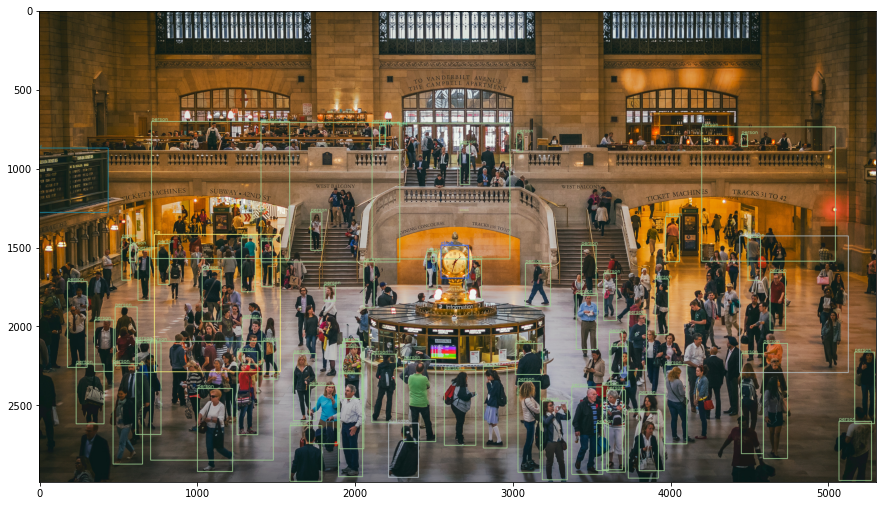

In [119]:
img_name = 'img6.jpg'
img = cv2.imread(f'openCV_dnn/{img_name}')

result = stridedInference(image, img_name, detector, tile_size_info=(900, 700, 701), nms_th=0.95)
image_out = display_box_strided(img, result, confidence_threshold=0.3)

## Uncomment the code below to get the image with bounding boxes as output        
# cv2.imwrite('image_result.jpg', image_out)

### Much better results as we can see